<a href="https://colab.research.google.com/github/Dennis-fast-ai/unpackAI/blob/main/DuckDuckGo_for_fastAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install libraries first ##
When you go back to your code try to make sure that it is all in a logical sequence, load the libraries you need at the beginning

In [ ]:
!pip install fastai --upgrade --use-feature=2020-resolver
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

## Install DuckDuckGo Image Scraper ##
You only need to run this once it will load the images onto your gdrive
After you have run it once you can comment it out by adding a # in front of the code

'#!pip install -q jmd_imagescraper

In [ ]:
!pip install -q jmd_imagescraper

## DuckDuckGo Image Scraper ##

Docs are at [joedockrill.github.io/jmd_imagescraper/](https://joedockrill.github.io/jmd_imagescraper/)

## Download images ##
When selectin images or any data, make sure that you don;t make your classes too broad. In this case in stead of looking for BMW, it is better to look for a specific type of BMW for instance "BMW sedans" if the data you are trying to group into a class is too varied you will struggle with getting good results.
Also don't be shy with how many images you load, 150 t0 200 per class will give a better result, 400 even better.
Pay attention to your data this is the foundation of your model. 

### Where to save the data ###
Where you save your data is important, not only so you know where to reference but also if it is permanently there or will be deleted after each session which happens if your data is stored in the /content folder

once you have run the code one time and the images are saved on your gdrive you don't need to runt he code again, you can # comment the code so it doesn't run again

In [ ]:
# setting up the root just makes it easier you don't need to type in the whole path each time
root = "/content/gdrive/MyDrive/fastai"
root

'/content/gdrive/MyDrive/fastai'

In [ ]:
from jmd_imagescraper.core import *  # dont't worry, it's designed to work with import *

params = {                           # use these parameters to try and limit the amount of cleaning you need to do later
    "max_results": 200,              # this can go up to 477 images at the time of writing
    "img_size":    ImgSize.Cached, 
    "img_type":    ImgType.Photo,
    "img_layout":  ImgLayout.Square, # we prefer square images in deep learning
    #"img_color":   ImgColor.Purple  # your data set might be specific to colour so add this if you need it
}

duckduckgo_search(root + '/cars', "bmw", "bmw sedans", **params)
duckduckgo_search(root + '/cars', "jeep", "jeepe", **params)
duckduckgo_search(root + '/cars', "toyota", "toyota sedans", **params)


In [ ]:
base_path = root + '/cars'
base_path

'/content/gdrive/MyDrive/fastai/cars'

## Clean the Images ##
Make sure that the images you have scraped from the internet are what you want there is an easy visual function in the scraper code.

In [ ]:
from jmd_imagescraper.imagecleaner import *

display_image_cleaner(base_path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

Cheat: looking at all these images in the image cleaner will take you hours, if you just go to your google drive directly you will be able to delete the unwanted images very quickly ... don't waste too much time doing it here

## Start fastAI code from here ##
Now you have a data set on your gdrive, you know where it is 

In [ ]:
path = root + '/cars'
path

'/content/gdrive/MyDrive/fastai/cars'

In [ ]:
fns = get_image_files(path)
fns

(#545) [Path('/content/gdrive/MyDrive/fastai/cars/bmw/001_3a125afb.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/002_e579a442.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/003_ef965239.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/004_9aeae21a.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/005_84e95df0.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/006_200dd8e3.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/007_c0b29aeb.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/008_ea414905.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/009_0ae5f7ae.jpg'),Path('/content/gdrive/MyDrive/fastai/cars/bmw/010_b41b8a50.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

Defining the data loaders and making the Data blocks

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = cars.dataloaders(path)

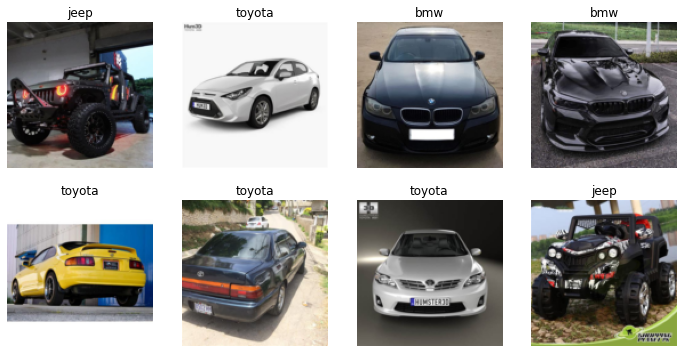

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

Using transforms to augment the data and make the model work harder to learn

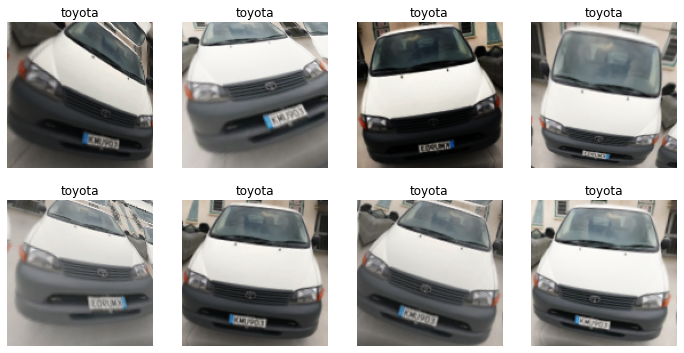

In [ ]:
cars = cars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Note when using RandomResizedCrop pay attention to the min_scale, generally it is 0.3 but you can adjust this ... in this case we want to maintain most of the car in the image to make sure of that 0.75 was selected. Try others and see the results.

In [ ]:
cars = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.75),
    batch_tfms=aug_transforms())
dls = cars.dataloaders(path)

At this point in the book the only learner we have looked at is learn.fine_tune - don't be afraid to run 10 or 20 epochs, now we want to see what happens.
In this case we managed to reach an 84% accuracy which isn't bad.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.648410,0.752326,0.302752,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.857279,0.674479,0.256881,00:11
1,0.710502,0.635426,0.211009,00:11
2,0.633213,0.648795,0.201835,00:11
3,0.520552,0.651311,0.220183,00:11
4,0.435156,0.616522,0.211009,00:11
5,0.364012,0.607664,0.155963,00:11
6,0.306666,0.628320,0.174312,00:11
7,0.263903,0.604535,0.174312,00:11
8,0.226588,0.582269,0.174312,00:11
9,0.201881,0.589118,0.174312,00:11


Look at the confusion matrix, when you see what kind of data confuses the computer you will start to get an understanding of what your data needs to look like in order to reduce the confusion.

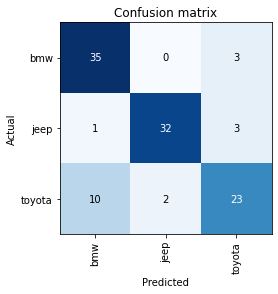

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

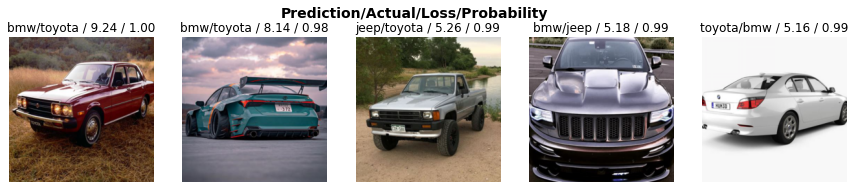

In [ ]:
interp.plot_top_losses(5, nrows=1)

Pushing the number of epochs to see just how far you can go before over fitting. in this case its starting to over fit.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.624923,0.752191,0.293578,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.906372,0.589720,0.266055,00:11
1,0.772539,0.584118,0.238532,00:11
2,0.689465,0.553376,0.201835,00:11
3,0.573522,0.559219,0.183486,00:11
4,0.498340,0.672805,0.192661,00:11
5,0.431184,0.588189,0.174312,00:11
6,0.377992,0.666019,0.174312,00:11
7,0.327037,0.769425,0.165138,00:11
8,0.281494,0.781836,0.174312,00:11
9,0.240323,0.764049,0.192661,00:11


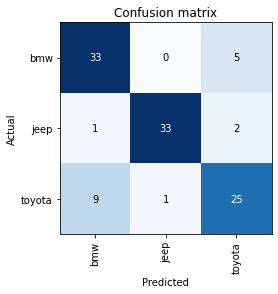

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()